In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBRegressor
import xgboost as xgb
import optuna
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from lightgbm import early_stopping, log_evaluation
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from lightgbm import LGBMRegressor
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import Ridge
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, ExtraTreesRegressor
from sklearn.preprocessing import StandardScaler
import pickle
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding, Concatenate, Reshape
import os
import matplotlib.ticker as ticker
import json
from IPython.display import display

C:\Users\anjal\Dissertation\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv("data.csv")

In [3]:
df.head()

,TXNDATE,BRANCHID,CODE,BRANCH,DISTRICT,PROVINCE,LATITUDE,LONGITUDE,CUSTOMER,TOTALTXNAMOUNT,TOTALCREDITAMOUNT,TOTALDEBITAMOUNT
0,31/03/2025,75,75,HOMAGAMA,COLOMBO,WESTERN,6.841287,80.002912,31,1665824.00,945600.00,720224.0
1,31/03/2025,214,214,URAGASMANHANDIYA,GALLE,SOUTHERN,6.349000,80.097864,16,1472377.00,1463381.00,8996.0
2,31/03/2025,11,11,KURUNEGALA,KURUNEGALA,NORTH WESTERN,7.489602,80.365024,16,1091657.00,998000.00,93657.0
3,31/03/2025,32,32,KANDANA,GAMPAHA,WESTERN,7.048289,79.899634,27,5768985.73,4436876.73,1332109.0
4,31/03/2025,66,66,KALAWANCHIKUDY,BATTICALOA,EASTERN,7.517505,81.786116,19,592609.24,568370.24,24239.0


# Feature Engineering

In [4]:
# Convert TXNDATE to datetime format
df['TXNDATE'] = pd.to_datetime(df['TXNDATE'], dayfirst=True)  

In [5]:
# Sort in ascending order
df = df.sort_values(by=['BRANCHID', 'TXNDATE']).reset_index(drop=True)

In [6]:
# Day of the week (0 = Monday, 6 = Sunday)
df['DayOfWeek'] = df['TXNDATE'].dt.dayofweek

# Is weekend? (Saturday = 5, Sunday = 6)
df['IsWeekend'] = df['DayOfWeek'].isin([5, 6]).astype(int)

# Month
df['Month'] = df['TXNDATE'].dt.month

# Year
df['Year'] = df['TXNDATE'].dt.year

In [7]:
# View new features
df[['TXNDATE', 'DayOfWeek', 'IsWeekend', 'Month', 'Year']].head(500)

,TXNDATE,DayOfWeek,IsWeekend,Month,Year
0,2022-04-01,4,0,4,2022
1,2022-04-02,5,1,4,2022
2,2022-04-04,0,0,4,2022
3,2022-04-05,1,0,4,2022
4,2022-04-06,2,0,4,2022
...,...,...,...,...,...
495,2023-12-01,4,0,12,2023
496,2023-12-02,5,1,12,2023
497,2023-12-04,0,0,12,2023
498,2023-12-05,1,0,12,2023


In [8]:
# Load holiday list from Excel
holidays_df = pd.read_csv("holidays.csv")

In [9]:
# Convert 'DATE' column to datetime format
holidays_df['DATE'] = pd.to_datetime(holidays_df['DATE'])

In [10]:
# Create a holiday list as a set for faster lookup
holiday_dates = set(holidays_df['DATE'])

# Create 'IsHoliday' column: 1 if date is a holiday, else 0
df['IsHoliday'] = df['TXNDATE'].isin(holiday_dates).astype(int)

In [11]:
df[['TXNDATE', 'IsHoliday']].head(1000)

,TXNDATE,IsHoliday
0,2022-04-01,0
1,2022-04-02,0
2,2022-04-04,0
3,2022-04-05,0
4,2022-04-06,0
...,...,...
995,2022-08-13,0
996,2022-08-15,0
997,2022-08-16,0
998,2022-08-17,0


In [12]:
# Create 'IsNonWorkingDay' column: 1 if date is a NonWorking Day, else 0
df['IsNonWorkingDay'] = ((df['IsWeekend'] == 1) | (df['IsHoliday'] == 1)).astype(int)

In [13]:
df.head(500)

,TXNDATE,BRANCHID,CODE,BRANCH,DISTRICT,PROVINCE,LATITUDE,LONGITUDE,CUSTOMER,TOTALTXNAMOUNT,TOTALCREDITAMOUNT,TOTALDEBITAMOUNT,DayOfWeek,IsWeekend,Month,Year,IsHoliday,IsNonWorkingDay
0,2022-04-01,1,1,HEAD OFFICE,COLOMBO,WESTERN,6.902243,79.86391,39,5907197.55,3119590.86,2787606.69,4,0,4,2022,0,0
1,2022-04-02,1,1,HEAD OFFICE,COLOMBO,WESTERN,6.902243,79.86391,3,44100.00,44100.00,0.00,5,1,4,2022,0,1
2,2022-04-04,1,1,HEAD OFFICE,COLOMBO,WESTERN,6.902243,79.86391,26,3310410.00,1953410.00,1357000.00,0,0,4,2022,0,0
3,2022-04-05,1,1,HEAD OFFICE,COLOMBO,WESTERN,6.902243,79.86391,30,25313073.75,15275573.75,10037500.00,1,0,4,2022,0,0
4,2022-04-06,1,1,HEAD OFFICE,COLOMBO,WESTERN,6.902243,79.86391,29,11524287.63,5638501.70,5885785.93,2,0,4,2022,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,2023-12-01,1,1,HEAD OFFICE,COLOMBO,WESTERN,6.902243,79.86391,43,22944753.25,18424680.25,4520073.00,4,0,12,2023,0,0
496,2023-12-02,1,1,HEAD OFFICE,COLOMBO,WESTERN,6.902243,79.86391,5,183150.00,183000.00,150.00,5,1,12,2023,0,1
497,2023-12-04,1,1,HEAD OFFICE,COLOMBO,WESTERN,6.902243,79.86391,50,10300308.26,8278492.34,2021815.92,0,0,12,2023,0,0
498,2023-12-05,1,1,HEAD OFFICE,COLOMBO,WESTERN,6.902243,79.86391,31,13677814.00,11421350.00,2256464.00,1,0,12,2023,0,0


### Lag Features (Past Values)

In [14]:
df['Lag1_Credit'] = df.groupby('BRANCHID')['TOTALCREDITAMOUNT'].shift(1)
df['Lag1_Debit'] = df.groupby('BRANCHID')['TOTALDEBITAMOUNT'].shift(1)
df['Lag1_Customers'] = df.groupby('BRANCHID')['CUSTOMER'].shift(1)

In [15]:
for lag in [1,2, 3, 7, 14]:
    df[f'Lag{lag}_Credit'] = df.groupby('BRANCHID')['TOTALCREDITAMOUNT'].shift(lag)
    df[f'Lag{lag}_Debit'] = df.groupby('BRANCHID')['TOTALDEBITAMOUNT'].shift(lag)
    df[f'Lag{lag}_Customers'] = df.groupby('BRANCHID')['CUSTOMER'].shift(lag)

In [16]:
df[['TOTALCREDITAMOUNT', 'TOTALDEBITAMOUNT', 'CUSTOMER',
    'Lag1_Credit', 'Lag1_Debit', 'Lag1_Customers', 
    'Lag2_Credit', 'Lag2_Debit', 'Lag2_Customers' ,
    'Lag3_Credit', 'Lag3_Debit', 'Lag3_Customers' ,
    'Lag7_Credit', 'Lag7_Debit', 'Lag7_Customers',
    'Lag14_Credit', 'Lag14_Debit', 'Lag14_Customers'
   ]].head(20)

,TOTALCREDITAMOUNT,TOTALDEBITAMOUNT,CUSTOMER,Lag1_Credit,Lag1_Debit,Lag1_Customers,Lag2_Credit,Lag2_Debit,Lag2_Customers,Lag3_Credit,Lag3_Debit,Lag3_Customers,Lag7_Credit,Lag7_Debit,Lag7_Customers,Lag14_Credit,Lag14_Debit,Lag14_Customers
0,3119590.86,2787606.69,39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,44100.00,0.00,3,3119590.86,2787606.69,39.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1953410.00,1357000.00,26,44100.00,0.00,3.0,3119590.86,2787606.69,39.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,15275573.75,10037500.00,30,1953410.00,1357000.00,26.0,44100.00,0.00,3.0,3119590.86,2787606.69,39.0,NaN,NaN,NaN,NaN,NaN,NaN
4,5638501.70,5885785.93,29,15275573.75,10037500.00,30.0,1953410.00,1357000.00,26.0,44100.00,0.00,3.0,NaN,NaN,NaN,NaN,NaN,NaN
5,1440080.00,9268215.18,39,5638501.70,5885785.93,29.0,15275573.75,10037500.00,30.0,1953410.00,1357000.00,26.0,NaN,NaN,NaN,NaN,NaN,NaN
6,2017655.00,46580149.98,72,1440080.00,9268215.18,39.0,5638501.70,5885785.93,29.0,15275573.75,10037500.00,30.0,NaN,NaN,NaN,NaN,NaN,NaN
7,64700.00,1015000.00,11,2017655.00,46580149.98,72.0,1440080.00,9268215.18,39.0,5638501.70,5885785.93,29.0,3119590.86,2787606.69,39.0,NaN,NaN,NaN
8,5640132.06,6495644.34,52,64700.00,1015000.00,11.0,2017655.00,46580149.98,72.0,1440080.00,9268215.18,39.0,44100.00,0.00,3.0,NaN,NaN,NaN
9,1840495.53,15660677.58,66,5640132.06,6495644.34,52.0,64700.00,1015000.00,11.0,2017655.00,46580149.98,72.0,1953410.00,1357000.00,26.0,NaN,NaN,NaN


### Rolling Statistics (Short-term & Long-term Trends)

In [17]:
# Rolling features for debits
df['Rolling7_DebitMean'] = df.groupby('BRANCHID')['TOTALDEBITAMOUNT'].transform(lambda x: x.shift(1).rolling(window=7).mean())
df['Rolling7_DebitStd'] = df.groupby('BRANCHID')['TOTALDEBITAMOUNT'].transform(lambda x: x.shift(1).rolling(window=7).std())

# Rolling features for customers
df['Rolling7_CustomersMean'] = df.groupby('BRANCHID')['CUSTOMER'].transform(lambda x: x.shift(1).rolling(window=7).mean())
df['Rolling7_CustomersStd'] = df.groupby('BRANCHID')['CUSTOMER'].transform(lambda x: x.shift(1).rolling(window=7).std())

# Rolling features for credit
df['Rolling7_CreditMean'] = df.groupby('BRANCHID')['TOTALCREDITAMOUNT'].transform(lambda x: x.shift(1).rolling(window=7).mean())
df['Rolling7_CreditStd'] = df.groupby('BRANCHID')['TOTALCREDITAMOUNT'].transform(lambda x: x.shift(1).rolling(window=7).std())

In [18]:
df.head(10)

,TXNDATE,BRANCHID,CODE,BRANCH,DISTRICT,PROVINCE,LATITUDE,LONGITUDE,CUSTOMER,TOTALTXNAMOUNT,...,Lag7_Customers,Lag14_Credit,Lag14_Debit,Lag14_Customers,Rolling7_DebitMean,Rolling7_DebitStd,Rolling7_CustomersMean,Rolling7_CustomersStd,Rolling7_CreditMean,Rolling7_CreditStd
0,2022-04-01,1,1,HEAD OFFICE,COLOMBO,WESTERN,6.902243,79.86391,39,5907197.55,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2022-04-02,1,1,HEAD OFFICE,COLOMBO,WESTERN,6.902243,79.86391,3,44100.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2022-04-04,1,1,HEAD OFFICE,COLOMBO,WESTERN,6.902243,79.86391,26,3310410.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2022-04-05,1,1,HEAD OFFICE,COLOMBO,WESTERN,6.902243,79.86391,30,25313073.75,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2022-04-06,1,1,HEAD OFFICE,COLOMBO,WESTERN,6.902243,79.86391,29,11524287.63,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,2022-04-07,1,1,HEAD OFFICE,COLOMBO,WESTERN,6.902243,79.86391,39,10708295.18,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,2022-04-08,1,1,HEAD OFFICE,COLOMBO,WESTERN,6.902243,79.86391,72,48597804.98,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,2022-04-09,1,1,HEAD OFFICE,COLOMBO,WESTERN,6.902243,79.86391,11,1079700.00,...,39.0,NaN,NaN,NaN,1.084518e+07,1.621363e+07,34.0,20.655911,4.212702e+06,5.173687e+06
8,2022-04-11,1,1,HEAD OFFICE,COLOMBO,WESTERN,6.902243,79.86391,52,12135776.40,...,3.0,NaN,NaN,NaN,1.059195e+07,1.637350e+07,30.0,22.181073,3.776289e+06,5.404937e+06
9,2022-04-12,1,1,HEAD OFFICE,COLOMBO,WESTERN,6.902243,79.86391,66,17501173.11,...,26.0,NaN,NaN,NaN,1.151990e+07,1.584883e+07,37.0,19.849433,4.575722e+06,5.169640e+06


In [19]:
# 3-day rolling averages
df['Rolling3_CreditMean'] = df.groupby('BRANCHID')['TOTALCREDITAMOUNT'].transform(lambda x: x.shift(1).rolling(3).mean())
df['Rolling3_DebitMean'] = df.groupby('BRANCHID')['TOTALDEBITAMOUNT'].transform(lambda x: x.shift(1).rolling(3).mean())
df['Rolling3_CustomersMean'] = df.groupby('BRANCHID')['CUSTOMER'].transform(lambda x: x.shift(1).rolling(3).mean())

# 3-day rolling standard deviation
df['Rolling3_CustomersStd'] = df.groupby('BRANCHID')['CUSTOMER'].transform(lambda x: x.shift(1).rolling(3).std())
df['Rolling3_CreditStd'] = df.groupby('BRANCHID')['TOTALCREDITAMOUNT'].transform(lambda x: x.shift(1).rolling(3).std())
df['Rolling3_DebitStd'] = df.groupby('BRANCHID')['TOTALDEBITAMOUNT'].transform(lambda x: x.shift(1).rolling(3).std())

In [20]:
# 30-day rolling averages
df['Rolling30_CreditMean'] = df.groupby('BRANCHID')['TOTALCREDITAMOUNT'].transform(lambda x: x.shift(1).rolling(30).mean())
df['Rolling30_DebitMean'] = df.groupby('BRANCHID')['TOTALDEBITAMOUNT'].transform(lambda x: x.shift(1).rolling(30).mean())
df['Rolling30_CustomersMean'] = df.groupby('BRANCHID')['CUSTOMER'].transform(lambda x: x.shift(1).rolling(30).mean())

# 30-day rolling standard deviation
df['Rolling30_CustomersStd'] = df.groupby('BRANCHID')['CUSTOMER'].transform(lambda x: x.shift(1).rolling(30).std())
df['Rolling30_CreditStd'] = df.groupby('BRANCHID')['TOTALCREDITAMOUNT'].transform(lambda x: x.shift(1).rolling(30).std())
df['Rolling30_DebitStd'] = df.groupby('BRANCHID')['TOTALDEBITAMOUNT'].transform(lambda x: x.shift(1).rolling(30).std())

### Combined Features (Lag & Rolling)

In [21]:
target_cols = ['Credit', 'Debit', 'Customers']
rolling_windows = [3, 7]

for target in target_cols:
    lag_col = f'Lag1_{target}'
    
    for window in rolling_windows:
        mean_col = f'Rolling{window}_{target}Mean'
        std_col = f'Rolling{window}_{target}Std'
        
        # Difference from mean
        df[f'{lag_col}_vs_Mean{window}'] = df[lag_col] - df[mean_col]
        
        # Ratio to mean (avoid division by 0)
        df[f'{lag_col}_Ratio_Mean{window}'] = df[lag_col] / (df[mean_col] + 1e-6)
        
        # Z-score (standardized deviation)
        df[f'{lag_col}_ZScore{window}'] = (df[lag_col] - df[mean_col]) / (df[std_col] + 1e-6)

In [22]:
df.head(100)

,TXNDATE,BRANCHID,CODE,BRANCH,DISTRICT,PROVINCE,LATITUDE,LONGITUDE,CUSTOMER,TOTALTXNAMOUNT,...,Lag1_Debit_ZScore3,Lag1_Debit_vs_Mean7,Lag1_Debit_Ratio_Mean7,Lag1_Debit_ZScore7,Lag1_Customers_vs_Mean3,Lag1_Customers_Ratio_Mean3,Lag1_Customers_ZScore3,Lag1_Customers_vs_Mean7,Lag1_Customers_Ratio_Mean7,Lag1_Customers_ZScore7
0,2022-04-01,1,1,HEAD OFFICE,COLOMBO,WESTERN,6.902243,79.86391,39,5907197.55,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2022-04-02,1,1,HEAD OFFICE,COLOMBO,WESTERN,6.902243,79.86391,3,44100.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2022-04-04,1,1,HEAD OFFICE,COLOMBO,WESTERN,6.902243,79.86391,26,3310410.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2022-04-05,1,1,HEAD OFFICE,COLOMBO,WESTERN,6.902243,79.86391,30,25313073.75,...,-0.017601,NaN,NaN,NaN,3.333333,1.147059,0.182849,NaN,NaN,NaN
4,2022-04-06,1,1,HEAD OFFICE,COLOMBO,WESTERN,6.902243,79.86391,29,11524287.63,...,1.145703,NaN,NaN,NaN,10.333333,1.525424,0.709139,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,2022-07-30,1,1,HEAD OFFICE,COLOMBO,WESTERN,6.902243,79.86391,8,905645.02,...,-0.028263,-1.551549e+06,0.635063,-0.270265,8.000000,1.266667,1.142857,8.571429,1.291262,0.656847
96,2022-07-31,1,1,HEAD OFFICE,COLOMBO,WESTERN,6.902243,79.86391,3,469800.00,...,-1.104915,-3.507263e+06,0.078797,-0.591054,-16.333333,0.328767,-1.076208,-17.714286,0.311111,-1.175122
97,2022-08-01,1,1,HEAD OFFICE,COLOMBO,WESTERN,6.902243,79.86391,26,3985750.00,...,-0.675737,-3.807263e+06,0.000000,-0.641611,-13.333333,0.183673,-0.704361,-22.714286,0.116667,-1.506810
98,2022-08-02,1,1,HEAD OFFICE,COLOMBO,WESTERN,6.902243,79.86391,26,12910647.61,...,1.150544,-8.854557e+05,0.783468,-0.151694,13.666667,2.108108,1.129772,2.285714,1.096385,0.166450


In [23]:
# Sort data by date per branch
df = df.sort_values(['BRANCHID', 'TXNDATE'], ascending=[True, True])

### Ratios & Deltas

In [24]:
# How much of the credit was withdrawn
df['Debit_to_Credit_Ratio'] = df['TOTALDEBITAMOUNT'] / (df['TOTALCREDITAMOUNT'] + 1)

In [25]:
#Cash in or out per customers visited
df['CashOut_Per_Customer'] = df['TOTALDEBITAMOUNT'] / (df['CUSTOMER'] + 1)
df['CashIn_Per_Customer'] = df['TOTALCREDITAMOUNT'] / (df['CUSTOMER'] + 1)

In [26]:
#  Net Cash Flow (Shows overall surplus or deficit of cash that day) - Response variable
df['NetCashFlow'] = df['TOTALCREDITAMOUNT'] - df['TOTALDEBITAMOUNT']

In [27]:
# Net Cash Flow per Customer
df['NetCashFlow_Per_Customer'] = df['NetCashFlow'] / (df['CUSTOMER'] + 1)

In [28]:
# Day-over-Day Deltas
df['Delta_Debit'] = df.groupby('BRANCHID')['TOTALDEBITAMOUNT'].diff(1)
df['Delta_Credit'] = df.groupby('BRANCHID')['TOTALCREDITAMOUNT'].diff(1)
df['Delta_Customers'] = df.groupby('BRANCHID')['CUSTOMER'].diff(1)

In [29]:
# Rolling Delta vs Mean (Z-score type feature) : helps to detect spikes or drops
df['Debit_ZScore'] = (df['TOTALDEBITAMOUNT'] - df['Rolling7_DebitMean']) / (df['Rolling7_DebitStd'] + 1)
df['Credit_ZScore'] = (df['TOTALCREDITAMOUNT'] - df['Rolling7_CreditMean']) / (df['Rolling7_CreditStd'] + 1)

### Time Positioning Flags

In [30]:
df['IsMonthStart'] = df['TXNDATE'].dt.is_month_start.astype(int)
df['IsMonthEnd'] = df['TXNDATE'].dt.is_month_end.astype(int)

In [31]:
# First and last 5 days of the month

# Ensure TXNDATE is datetime
df['TXNDATE'] = pd.to_datetime(df['TXNDATE'])

# Day of the month
df['DayOfMonth'] = df['TXNDATE'].dt.day

# Number of days in the month
df['DaysInMonth'] = df['TXNDATE'].dt.days_in_month

# Is it in the first 5 days of the month?
df['IsFirst5Days'] = (df['DayOfMonth'] <= 5).astype(int)

# Is it in the last 5 days of the month?
df['IsLast5Days'] = (df['DayOfMonth'] > (df['DaysInMonth'] - 5)).astype(int)

In [32]:
# Load the inflation dataset
inflation = pd.read_csv("inflation.csv")

In [33]:
# Make inflation 'Month' is zero-padded to match datetime format
inflation['Month'] = inflation['Month'].astype(int)
inflation['Year'] = inflation['Year'].astype(int)

In [34]:
# Merge the inflation data into main dataframe
df = df.merge(inflation, on=['Year', 'Month'], how='left')

In [35]:
# Check for missing inflation values
missing_inflation = df[df['NCPI_Index'].isna()]
print(f"Rows with missing inflation data: {len(missing_inflation)}")

Rows with missing inflation data: 0


In [36]:
df.head(500)

,TXNDATE,BRANCHID,CODE,BRANCH,DISTRICT,PROVINCE,LATITUDE,LONGITUDE,CUSTOMER,TOTALTXNAMOUNT,...,Credit_ZScore,IsMonthStart,IsMonthEnd,DayOfMonth,DaysInMonth,IsFirst5Days,IsLast5Days,NCPI_Index,NCPI-Headline_Inflation,NCPI-Core_Inflation
0,2022-04-01,1,1,HEAD OFFICE,COLOMBO,WESTERN,6.902243,79.86391,39,5907197.55,...,NaN,1,0,1,30,1,0,151.7,33.8,27.9
1,2022-04-02,1,1,HEAD OFFICE,COLOMBO,WESTERN,6.902243,79.86391,3,44100.00,...,NaN,0,0,2,30,1,0,151.7,33.8,27.9
2,2022-04-04,1,1,HEAD OFFICE,COLOMBO,WESTERN,6.902243,79.86391,26,3310410.00,...,NaN,0,0,4,30,1,0,151.7,33.8,27.9
3,2022-04-05,1,1,HEAD OFFICE,COLOMBO,WESTERN,6.902243,79.86391,30,25313073.75,...,NaN,0,0,5,30,1,0,151.7,33.8,27.9
4,2022-04-06,1,1,HEAD OFFICE,COLOMBO,WESTERN,6.902243,79.86391,29,11524287.63,...,NaN,0,0,6,30,0,0,151.7,33.8,27.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,2023-12-01,1,1,HEAD OFFICE,COLOMBO,WESTERN,6.902243,79.86391,43,22944753.25,...,-0.155821,1,0,1,31,1,0,208.8,4.2,0.9
496,2023-12-02,1,1,HEAD OFFICE,COLOMBO,WESTERN,6.902243,79.86391,5,183150.00,...,-0.629944,0,0,2,31,1,0,208.8,4.2,0.9
497,2023-12-04,1,1,HEAD OFFICE,COLOMBO,WESTERN,6.902243,79.86391,50,10300308.26,...,-0.443404,0,0,4,31,1,0,208.8,4.2,0.9
498,2023-12-05,1,1,HEAD OFFICE,COLOMBO,WESTERN,6.902243,79.86391,31,13677814.00,...,-0.405258,0,0,5,31,1,0,208.8,4.2,0.9


# Preprocessing

### 1. Date Parsing & Sorting

In [37]:
df["TXNDATE"] = pd.to_datetime(df["TXNDATE"], format="%d/%m/%Y")
df.sort_values(["BRANCHID", "TXNDATE"], inplace=True)

### 2. Categorical Encoding

In [38]:
df_ = df.copy()
for col in ["BRANCH", "DISTRICT", "PROVINCE", "CODE"]:
    df_[col] = LabelEncoder().fit_transform(df[col])

### 3. Handle Missing Values 

In [39]:
rolling_lag_cols = [
    "Lag1_Credit",	"Lag1_Debit",	"Lag1_Customers",	"Lag2_Credit",	"Lag2_Debit",	"Lag2_Customers",	
    "Lag3_Credit",	"Lag3_Debit",	"Lag3_Customers",	"Lag7_Credit",	"Lag7_Debit",	"Lag7_Customers",	
    "Lag14_Credit",	"Lag14_Debit",	"Lag14_Customers",
    "Rolling7_DebitMean", "Rolling7_DebitStd", "Rolling7_CustomersMean", "Rolling7_CustomersStd", "Rolling7_CreditMean", "Rolling7_CreditStd",
    "Rolling3_CreditMean", "Rolling3_DebitMean", "Rolling3_CustomersMean", "Rolling3_CustomersStd", "Rolling3_CreditStd", "Rolling3_DebitStd",
    "Rolling30_CreditMean", "Rolling30_DebitMean", "Rolling30_CustomersMean", "Rolling30_CustomersStd", "Rolling30_CreditStd", "Rolling30_DebitStd",
    "Lag1_Credit_vs_Mean3",	"Lag1_Credit_Ratio_Mean3",	"Lag1_Credit_ZScore3",	"Lag1_Credit_vs_Mean7",	"Lag1_Credit_Ratio_Mean7",	
    "Lag1_Credit_ZScore7",	"Lag1_Debit_vs_Mean3",	"Lag1_Debit_Ratio_Mean3",	"Lag1_Debit_ZScore3",	"Lag1_Debit_vs_Mean7",	"Lag1_Debit_Ratio_Mean7",	
    "Lag1_Debit_ZScore7",	"Lag1_Customers_vs_Mean3",	"Lag1_Customers_Ratio_Mean3",	"Lag1_Customers_ZScore3",	"Lag1_Customers_vs_Mean7",	
    "Lag1_Customers_Ratio_Mean7",	"Lag1_Customers_ZScore7", "Delta_Debit", "Delta_Credit", "Delta_Customers", "Debit_ZScore", "Credit_ZScore"
]

In [40]:
df_cleaned = df_.dropna(subset=rolling_lag_cols)

# Data Split

In [41]:
# Ensure TXNDATE is datetime
df_cleaned["TXNDATE"] = pd.to_datetime(df_cleaned["TXNDATE"])

split_date = pd.to_datetime("2025-01-01")

train_df = df_cleaned[df_cleaned["TXNDATE"] < split_date].copy()
test_df = df_cleaned[df_cleaned["TXNDATE"] >= split_date].copy()

print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)

C:\Users\anjal\AppData\Local\Temp\ipykernel_14576\2230278199.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned["TXNDATE"] = pd.to_datetime(df_cleaned["TXNDATE"])


Train shape: (150104, 88)
Test shape: (15603, 88)


In [42]:
# Define target 
target_col = "NetCashFlow"

In [43]:
# Distribution of the "NetCashFlow"
print(df_cleaned["NetCashFlow"].describe())

count    1.657070e+05
mean     3.656068e+05
std      2.899138e+06
min     -2.025257e+08
25%     -6.428901e+04
50%      7.285000e+04
75%      7.190285e+05
max      1.354997e+08
Name: NetCashFlow, dtype: float64


In [44]:
drop_cols = ["TXNDATE", "BRANCHID", "NetCashFlow", "NetCashFlow_Per_Customer", "TOTALTXNAMOUNT"]
feature_cols = [col for col in train_df.columns if col not in drop_cols]

In [45]:
X_train1 = train_df[feature_cols]
y_train = train_df[target_col]

X_test1 = test_df[feature_cols]
y_test = test_df[target_col]

## Correlation Check

In [46]:
# Compute correlation matrix on X_train1
cor_matrix = X_train1.corr().abs()

# Identify pairs with high correlation
high_corr_pairs = []
for i in range(len(cor_matrix.columns)):
    for j in range(i):
        if cor_matrix.iloc[i, j] > 0.8:
            f1 = cor_matrix.columns[i]
            f2 = cor_matrix.columns[j]
            high_corr_pairs.append((f1, f2, cor_matrix.iloc[i, j]))

# Sort and display
high_corr_df = pd.DataFrame(high_corr_pairs, columns=['Feature_1', 'Feature_2', 'Correlation'])
high_corr_df = high_corr_df.sort_values(by='Correlation', ascending=False)

print("Highly Correlated Feature Pairs (|correlation| > 0.8):")
print(high_corr_df)

Highly Correlated Feature Pairs (|correlation| > 0.8):
                     Feature_1                   Feature_2  Correlation
31         NCPI-Core_Inflation     NCPI-Headline_Inflation     0.996125
0              IsNonWorkingDay                   IsWeekend     0.982996
6        Rolling3_CustomersStd      Rolling3_CustomersMean     0.935689
21          Lag1_Debit_ZScore7      Lag1_Debit_Ratio_Mean7     0.934272
18         Lag1_Credit_ZScore7     Lag1_Credit_Ratio_Mean7     0.927192
19          Lag1_Debit_ZScore3      Lag1_Debit_Ratio_Mean3     0.925675
28      Lag1_Customers_ZScore7  Lag1_Customers_Ratio_Mean7     0.918917
16         Lag1_Credit_ZScore3     Lag1_Credit_Ratio_Mean3     0.914020
9         Rolling30_CreditMean         Rolling7_CreditMean     0.912342
23     Lag1_Customers_vs_Mean7              Lag1_Customers     0.896026
4          Rolling3_CreditMean         Rolling7_CreditMean     0.893410
14         Rolling30_CreditStd        Rolling30_CreditMean     0.886075
24     La

In [47]:
# Calculate correlation of each feature with target
feature_target_corr = X_train1.corrwith(y_train).abs()

# Drop the feature with lower correlation to target
to_drop = []
for f1, f2, _ in high_corr_pairs:
    if f1 in to_drop or f2 in to_drop:
        continue  
    if feature_target_corr[f1] < feature_target_corr[f2]:
        to_drop.append(f1)
    else:
        to_drop.append(f2)

print("\nFeatures to drop due to high multicollinearity:")
print(to_drop)

# Drop from training and test sets
X_train = X_train1.drop(columns=to_drop)
X_test = X_test1.drop(columns=to_drop)



Features to drop due to high multicollinearity:
['IsWeekend', 'Rolling7_DebitMean', 'Rolling7_CustomersStd', 'Rolling7_CreditStd', 'Rolling3_CreditMean', 'Rolling3_CustomersStd', 'Rolling3_DebitStd', 'Rolling7_CreditMean', 'Rolling30_DebitMean', 'Rolling30_CreditStd', 'Lag1_Credit_Ratio_Mean3', 'Lag1_Credit_vs_Mean3', 'Lag1_Credit_Ratio_Mean7', 'Lag1_Debit_Ratio_Mean3', 'Lag1_Debit_vs_Mean3', 'Lag1_Debit_Ratio_Mean7', 'Lag1_Customers_ZScore3', 'Lag1_Customers_vs_Mean7', 'Lag1_Customers_Ratio_Mean3', 'Lag1_Customers_Ratio_Mean7', 'Year', 'NCPI-Core_Inflation']


### Comparison of ML findings

In [48]:
class WeightedBlender:
    def __init__(self, model1, model2, weight1, weight2, features1, features2):
        self.model1 = model1
        self.model2 = model2
        self.weight1 = weight1
        self.weight2 = weight2
        self.features1 = features1
        self.features2 = features2

    def predict(self, X):
        X1 = X[self.features1]
        X2 = X[self.features2]
        pred1 = self.model1.predict(X1)
        pred2 = self.model2.predict(X2)
        return self.weight1 * pred1 + self.weight2 * pred2

In [49]:
# XGBoost
with open("xgb_best_model.pkl", "rb") as f:
    xgb_model = pickle.load(f)
with open("xgb_selected_features.pkl", "rb") as f:
    xgb_features = pickle.load(f)
X_test_xgb = X_test[xgb_features]
xgb_pred = xgb_model.predict(X_test_xgb)

# LightGBM
with open("lgbm_best_model.pkl", "rb") as f:
    lgbm_model = pickle.load(f)
with open("lgbm_selected_features.pkl", "rb") as f:
    lgbm_features = pickle.load(f)
X_test_lgb = X_test[lgbm_features]
lgb_pred = lgbm_model.predict(X_test_lgb)

# Weighted Blend
with open("weighted_blended_model.pkl", "rb") as f:
    blended_model = pickle.load(f)
y_pred_blended = blended_model.predict(X_test)

# Stacked Model
with open("stacked_meta_model.pkl", "rb") as f:
    meta_model = pickle.load(f)

stacked_test = pd.DataFrame({
    "XGB_Pred": xgb_pred,
    "LGB_Pred": lgb_pred,
    "Avg_Pred": (xgb_pred + lgb_pred) / 2,
    "Diff_Pred": xgb_pred - lgb_pred,
    "Ratio_Pred": xgb_pred / (lgb_pred + 1e-6),
    "Min_Pred": np.minimum(xgb_pred, lgb_pred),
    "Max_Pred": np.maximum(xgb_pred, lgb_pred)
})
final_pred = meta_model.predict(stacked_test)

# --- Evaluate all models ---
def evaluate(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return rmse, mae, r2

results = {
    "Model": ["XGBoost", "LightGBM", "Weighted Blend", "Stacked Model"],
    "RMSE": [],
    "MAE": [],
    "R²": []
}

# Calculate metrics
for pred in [xgb_pred, lgb_pred, y_pred_blended, final_pred]:
    rmse, mae, r2 = evaluate(y_test, pred)
    results["RMSE"].append(rmse)
    results["MAE"].append(mae)
    results["R²"].append(r2)

# Create DataFrame
results_df = pd.DataFrame(results)

# Format numbers for readability
results_df["RMSE"] = results_df["RMSE"].map("{:,.2f}".format)
results_df["MAE"] = results_df["MAE"].map("{:,.2f}".format)
results_df["R²"] = results_df["R²"].map("{:.4f}".format)

print("\nModel Performance Summary:")
print(results_df)


Model Performance Summary:
            Model          RMSE        MAE      R²
0         XGBoost    987,557.80  88,086.85  0.9371
1        LightGBM  1,133,910.31  96,585.39  0.9171
2  Weighted Blend  1,016,417.78  81,251.71  0.9334
3   Stacked Model  1,283,199.91  91,571.81  0.8938


# Final Model - XGB 60% and LGBM 40% blended model

In [50]:
# Load Saved Blended Model
with open("weighted_blended_model.pkl", "rb") as f:
    blended_model = pickle.load(f)


# Predict on Test Set
y_pred = blended_model.predict(X_test)
abs_errors = np.abs(y_test - y_pred)



# Create DataFrame with Branch IDs and Errors
error_df = pd.DataFrame({
    "BRANCHID": test_df["BRANCHID"].values,
    "AbsoluteError": abs_errors
})


# Compute 90th Percentile Buffer Per Branch
branch_buffers = (
    error_df.groupby("BRANCHID")["AbsoluteError"]
    .quantile(0.90) #90% of errors are smaller than the buffer amount
    .reset_index()
    .rename(columns={"AbsoluteError": "BufferAmount"})
)

# Save buffer table for deployment use
#branch_buffers.to_csv("branch_buffers.csv", index=False) #Already saved
print("Saved branch-level 90th percentile buffers to 'branch_buffers.csv'")


Saved branch-level 90th percentile buffers to 'branch_buffers.csv'


In [51]:
# Inputs
branch_id = 210
start_date = "2025-03-17"
end_date = "2025-03-21"

# Load weighted blended model
with open("weighted_blended_model.pkl", "rb") as f:
    blended_model = pickle.load(f)

# Predict on full test set features
y_pred = blended_model.predict(X_test)

# Create a DataFrame for error calculation and merging
results_df = test_df.copy()

# Add Actual values directly (no dependency on code 1 or 2)
results_df["Actual"] = test_df["NetCashFlow"] 


results_df["Predicted"] = y_pred
results_df["ErrorAbs"] = np.abs(results_df["Actual"] - results_df["Predicted"])

# Load or calculate buffer amounts
buffer_csv = "branch_buffers.csv"

if os.path.exists(buffer_csv):
    branch_buffers = pd.read_csv(buffer_csv)
    print("Loaded branch buffers from CSV.")
else:
    branch_buffers = (
        results_df.groupby("BRANCHID")["ErrorAbs"]
        .quantile(0.90)
        .reset_index()
        .rename(columns={"ErrorAbs": "BufferAmount"})
    )
    branch_buffers.to_csv(buffer_csv, index=False)
    print("Calculated and saved branch buffers CSV.")

# Merge buffers back
results_df = results_df.merge(branch_buffers, on="BRANCHID", how="left")
results_df["BufferAmount"].fillna(0, inplace=True)
results_df["FinalPredictionWithBuffer"] = results_df["Predicted"] + results_df["BufferAmount"]

# Filter by branch and date range
mask = (
    (results_df["BRANCHID"] == branch_id) &
    (results_df["TXNDATE"] >= pd.to_datetime(start_date)) &
    (results_df["TXNDATE"] <= pd.to_datetime(end_date))
)

filtered_df = results_df.loc[mask, [
    "TXNDATE", "BRANCHID", "Predicted", "BufferAmount", "FinalPredictionWithBuffer", "Actual"
]].copy()

# Rename columns for presentation
filtered_df.rename(columns={
    "TXNDATE": "Date",
    "Predicted": "Predicted NetCashFlow",
    "BufferAmount": "Buffer (90th Percentile Abs Error)",
    "FinalPredictionWithBuffer": "Final Prediction + Buffer",
    "Actual": "Actual NetCashFlow"
}, inplace=True)

# Apply currency formatting
def format_lkr(x):
    return f"LKR {x:,.0f}"

formatted_df = filtered_df.copy()
for col in [
    "Predicted NetCashFlow",
    "Buffer (90th Percentile Abs Error)",
    "Final Prediction + Buffer",
    "Actual NetCashFlow"
]:
    formatted_df[col] = formatted_df[col].apply(format_lkr)

# Display formatted table
from IPython.display import display
display(formatted_df)

Loaded branch buffers from CSV.


C:\Users\anjal\AppData\Local\Temp\ipykernel_14576\2012633727.py:41: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  results_df["BufferAmount"].fillna(0, inplace=True)


,Date,BRANCHID,Predicted NetCashFlow,Buffer (90th Percentile Abs Error),Final Prediction + Buffer,Actual NetCashFlow
12597,2025-03-17,210,"LKR -229,494","LKR 71,963","LKR -157,530","LKR -216,388"
12598,2025-03-18,210,"LKR -515,423","LKR 71,963","LKR -443,460","LKR -582,875"
12599,2025-03-19,210,"LKR 53,296","LKR 71,963","LKR 125,260","LKR 42,555"
12600,2025-03-20,210,"LKR 843,077","LKR 71,963","LKR 915,040","LKR 818,902"
12601,2025-03-21,210,"LKR -494,024","LKR 71,963","LKR -422,060","LKR -516,740"


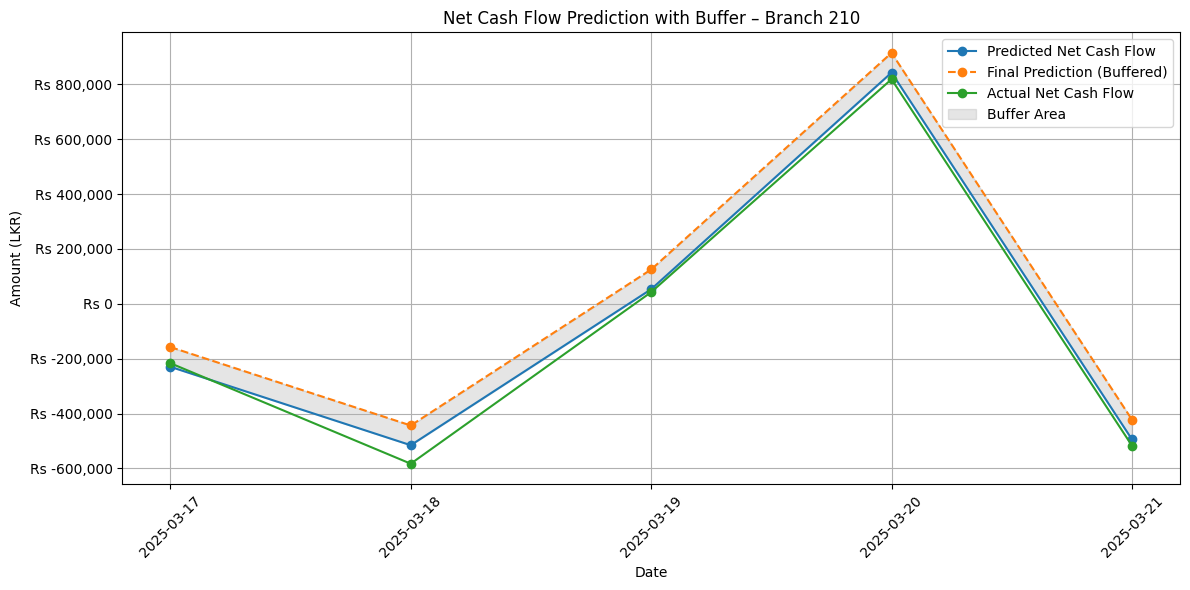

In [52]:
# Ensure datetime type
import matplotlib.ticker as ticker

filtered_df['Date'] = pd.to_datetime(filtered_df['Date'])

# Plot
plt.figure(figsize=(12, 6))
plt.plot(
    filtered_df['Date'],
    filtered_df['Predicted NetCashFlow'],
    label='Predicted Net Cash Flow',
    marker='o'
)
plt.plot(
    filtered_df['Date'],
    filtered_df['Final Prediction + Buffer'],
    label='Final Prediction (Buffered)',
    marker='o',
    linestyle='--'
)
plt.plot(
    filtered_df['Date'],
    filtered_df['Actual NetCashFlow'],
    label='Actual Net Cash Flow',
    marker='o',
    linestyle='-'
)

# Fill between predicted and buffered
plt.fill_between(
    filtered_df['Date'],
    filtered_df['Predicted NetCashFlow'],
    filtered_df['Final Prediction + Buffer'],
    color='gray',
    alpha=0.2,
    label='Buffer Area'
)

# Currency format for LKR
formatter = ticker.FuncFormatter(lambda x, _: f"Rs {x:,.0f}")
plt.gca().yaxis.set_major_formatter(formatter)


plt.xticks(
    ticks=filtered_df['Date'], 
    labels=filtered_df['Date'].dt.strftime('%Y-%m-%d'),
    rotation=45
)

# Set labels and title
plt.title(f"Net Cash Flow Prediction with Buffer – Branch {branch_id}")
plt.xlabel("Date")
plt.ylabel("Amount (LKR)")
plt.grid(True)
plt.legend()
plt.tight_layout()

plt.show()


### Multiple branches

In [53]:
chosen_branches = [23, 215, 78, 118, 520]  # Example branch IDs
selected_date = "2025-02-05"  # Single date to filter

# --- Load weighted blended model ---
with open("weighted_blended_model.pkl", "rb") as f:
    blended_model = pickle.load(f)

# --- Predict on full test set ---
y_pred = blended_model.predict(X_test)

# --- Create results DataFrame ---
results_df = test_df.copy()

# Ensure Actual values exist and are aligned
# Option 1: use y_test if available
#results_df["Actual"] = pd.Series(y_test).reset_index(drop=True)
results_df["Actual"] = test_df["NetCashFlow"] 

# --- Add predicted values ---
results_df["Predicted"] = y_pred

# --- Compute absolute errors ---
results_df["ErrorAbs"] = np.abs(results_df["Actual"] - results_df["Predicted"])



# --- Load or calculate buffer amounts ---
buffer_csv = "branch_buffers.csv"
if os.path.exists(buffer_csv):
    branch_buffers = pd.read_csv(buffer_csv)
    print("Loaded branch buffers from CSV.")
else:
    branch_buffers = (
        results_df.groupby("BRANCHID")["ErrorAbs"]
        .quantile(0.90)
        .reset_index()
        .rename(columns={"ErrorAbs": "BufferAmount"})
    )
    branch_buffers.to_csv(buffer_csv, index=False)
    print("Calculated and saved branch buffers CSV.")

# --- Merge buffers ---
results_df = results_df.merge(branch_buffers, on="BRANCHID", how="left")
results_df["BufferAmount"].fillna(0, inplace=True)
results_df["FinalPredictionWithBuffer"] = results_df["Predicted"] + results_df["BufferAmount"]

# --- Filter for chosen branches and selected date ---
mask = (
    results_df["BRANCHID"].isin(chosen_branches) &
    (results_df["TXNDATE"] == pd.to_datetime(selected_date))
)

filtered_df = results_df.loc[mask, [
    "TXNDATE", "BRANCHID", "Predicted", "BufferAmount", "FinalPredictionWithBuffer", "Actual"
]].copy()

# --- Rename columns for clarity ---
filtered_df.rename(columns={
    "TXNDATE": "Date",
    "Predicted": "Predicted NetCashFlow",
    "BufferAmount": "Buffer (90th Percentile Abs Error)",
    "FinalPredictionWithBuffer": "Final Prediction + Buffer",
    "Actual": "Actual NetCashFlow"
}, inplace=True)

# --- Apply currency formatting ---
def format_lkr(x):
    return f"LKR {x:,.0f}"

formatted_df = filtered_df.copy()
for col in [
    "Predicted NetCashFlow",
    "Buffer (90th Percentile Abs Error)",
    "Final Prediction + Buffer",
    "Actual NetCashFlow"
]:
    formatted_df[col] = formatted_df[col].apply(format_lkr)

# --- Display ---
from IPython.display import display
display(formatted_df)


Loaded branch buffers from CSV.


C:\Users\anjal\AppData\Local\Temp\ipykernel_14576\2737704410.py:44: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  results_df["BufferAmount"].fillna(0, inplace=True)


,Date,BRANCHID,Predicted NetCashFlow,Buffer (90th Percentile Abs Error),Final Prediction + Buffer,Actual NetCashFlow
1637,2025-02-05,23,"LKR 1,832,766","LKR 53,655","LKR 1,886,420","LKR 1,834,371"
5661,2025-02-05,78,"LKR 2,147,593","LKR 26,055","LKR 2,173,648","LKR 2,110,857"
8592,2025-02-05,118,"LKR 1,655,260","LKR 36,858","LKR 1,692,118","LKR 1,655,141"
12902,2025-02-05,215,"LKR -5,872","LKR 19,482","LKR 13,610",LKR -500
14245,2025-02-05,520,"LKR 813,519","LKR 23,869","LKR 837,388","LKR 829,825"


# Final result (Branch wise Net Cash Flow)

In [54]:
# --- Load branch map (Name → ID) ---
with open("branch_map.json", "r", encoding="utf-8") as f:
    branch_map = json.load(f)

# Convert to reverse map: ID → Name
branch_map_rev = {v: k for k, v in branch_map.items()}

selected_date = "2025-02-05"  # Single date to filter

# --- Load weighted blended model ---
with open("weighted_blended_model.pkl", "rb") as f:
    blended_model = pickle.load(f)

# --- Predict on full test set ---
y_pred = blended_model.predict(X_test)

# --- Create results DataFrame ---
results_df = test_df.copy()
results_df["Actual"] = test_df["NetCashFlow"]
results_df["Predicted"] = y_pred
results_df["ErrorAbs"] = np.abs(results_df["Actual"] - results_df["Predicted"])

# --- Load or calculate buffer amounts ---
buffer_csv = "branch_buffers.csv"
if os.path.exists(buffer_csv):
    branch_buffers = pd.read_csv(buffer_csv)
    print("Loaded branch buffers from CSV.")
else:
    branch_buffers = (
        results_df.groupby("BRANCHID")["ErrorAbs"]
        .quantile(0.90)
        .reset_index()
        .rename(columns={"ErrorAbs": "BufferAmount"})
    )
    branch_buffers.to_csv(buffer_csv, index=False)
    print("Calculated and saved branch buffers CSV.")

# --- Merge buffers ---
results_df = results_df.merge(branch_buffers, on="BRANCHID", how="left")
results_df["BufferAmount"].fillna(0, inplace=True)
results_df["FinalPredictionWithBuffer"] = results_df["Predicted"] + results_df["BufferAmount"]

# --- Filter for all branches but only the selected date ---
mask = results_df["TXNDATE"] == pd.to_datetime(selected_date)
date_filtered_df = results_df.loc[mask, [
    "TXNDATE", "BRANCHID", "Predicted", "BufferAmount",
    "FinalPredictionWithBuffer", "Actual"
]].copy()

# --- Add Branch Name ---
date_filtered_df["Branch Name"] = date_filtered_df["BRANCHID"].map(branch_map_rev)

# --- Rename columns for clarity ---
date_filtered_df.rename(columns={
    "TXNDATE": "Date",
    "Predicted": "Predicted NetCashFlow",
    "BufferAmount": "Buffer (90th Percentile Abs Error)",
    "FinalPredictionWithBuffer": "Final Prediction + Buffer",
    "Actual": "Actual NetCashFlow"
}, inplace=True)

# --- Reorder columns to show Branch Name beside ID ---
date_filtered_df = date_filtered_df[
    ["Date", "BRANCHID", "Branch Name",
     "Predicted NetCashFlow", "Buffer (90th Percentile Abs Error)",
     "Final Prediction + Buffer", "Actual NetCashFlow"]
]

# --- Sort by Branch Name (case-insensitive) ---
date_filtered_df = date_filtered_df.sort_values(
    by="Branch Name",
    key=lambda col: col.str.lower()
).reset_index(drop=True)

# --- Apply currency formatting ---
def format_lkr(x):
    return f"LKR {x:,.0f}"

formatted_date_df = date_filtered_df.copy()
for col in [
    "Predicted NetCashFlow",
    "Buffer (90th Percentile Abs Error)",
    "Final Prediction + Buffer",
    "Actual NetCashFlow"
]:
    formatted_date_df[col] = formatted_date_df[col].apply(format_lkr)

# --- Display table for all branches on the chosen date ---
display(formatted_date_df)


Loaded branch buffers from CSV.


C:\Users\anjal\AppData\Local\Temp\ipykernel_14576\2099931153.py:40: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  results_df["BufferAmount"].fillna(0, inplace=True)


,Date,BRANCHID,Branch Name,Predicted NetCashFlow,Buffer (90th Percentile Abs Error),Final Prediction + Buffer,Actual NetCashFlow
0,2025-02-05,152,ADDALAICHENAI,"LKR 68,251","LKR 24,732","LKR 92,983","LKR 65,313"
1,2025-02-05,55,AKKARAIPATTU,"LKR 938,061","LKR 35,868","LKR 973,929","LKR 936,537"
2,2025-02-05,87,AKURESSA,"LKR -286,844","LKR 34,028","LKR -252,815","LKR -266,159"
3,2025-02-05,500,ALUTH MAWATHA,"LKR 3,836,673","LKR 73,380","LKR 3,910,053","LKR 3,848,604"
4,2025-02-05,69,ALUTHGAMA,"LKR -1,217,642","LKR 34,349","LKR -1,183,293","LKR -1,233,395"
...,...,...,...,...,...,...,...
208,2025-02-05,215,WELIGAMA,"LKR -5,872","LKR 19,482","LKR 13,610",LKR -500
209,2025-02-05,61,WELIMADA,"LKR 3,967,827","LKR 58,822","LKR 4,026,649","LKR 4,034,190"
210,2025-02-05,533,WELLAWATTA,"LKR -2,780,969","LKR 35,944","LKR -2,745,025","LKR -2,808,775"
211,2025-02-05,149,WELLAWATTE CITY,"LKR 4,341,117","LKR 150,988","LKR 4,492,105","LKR 4,417,270"
